In [1]:
# !pip install tavily-python 
!pip install -U tavily-python langchain_community --quiet
!pip install autogen-agentchat~=0.2 autogen psutil --quiet
# !pip install -q langchain-openai termcolor langchain_community duckduckgo_search wikipedia openapi-python-client==0.12.3 langgraph langchain_experimental yfinance
!pip install -q langchain-openai langchain-anthropic termcolor langchain_community duckduckgo_search wikipedia openapi-python-client langgraph langchain_experimental openai --quiet


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import getpass
import os

os.environ["TAVILY_API_KEY"] = "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"

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [4]:
import os
import autogen
from typing import Literal

from pydantic import BaseModel, Field
from typing_extensions import Annotated

import autogen
from autogen.cache import Cache
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langgraph.graph import END, StateGraph, START

INFERENCE_SERVER_URL = "http://localhost:8000"
MODEL_NAME = "ibm-granite/granite-3.0-8b-instruct"
API_KEY= "alanliuxiang"

In [5]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(
    openai_api_key=API_KEY,
    openai_api_base= f"{INFERENCE_SERVER_URL}/v1",
    model_name=MODEL_NAME,
    top_p=0.92,
    temperature=0.01,
    max_tokens=512,
    presence_penalty=1.03,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]
)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]


tool = TavilySearchResults(max_results=2)
tools = [tool,human_assistance]
# tool.invoke("What's a 'node' in LangGraph?")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")


In [7]:
graph = graph_builder.compile(checkpointer=memory)

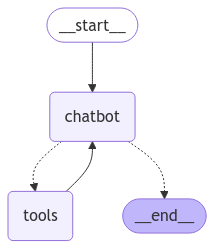

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
config = {"configurable": {"thread_id": "1"}}

In [10]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (chatcmpl-tool-f64b593051ae4a60b57db6417fa11fcd)
 Call ID: chatcmpl-tool-f64b593051ae4a60b57db6417fa11fcd
  Args:
    query: I need some expert guidance for building an AI agent.
================================= Tool Message =================================
Name: human_assistance

Error: human_assistance is not a valid tool, try one of [tavily_search_results_json].
I'm glad to help you with your AI agent project! However, I'm an AI language model and I don't have the ability to directly request assistance from humans. But I can certainly provide you with some guidance and resources to help you build your AI agent.

Here are some steps you can follow:

1. Define the purpose and scope of your AI agent. Wha

In [11]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
I'm sorry, I don't have the ability to remember personal information such as names. However, I'm here to assist you with any questions or tasks you have.================================== Ai Message ==================================

I'm sorry, I don't have the ability to remember personal information such as names. However, I'm here to assist you with any questions or tasks you have.


In [12]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
I'm sorry, I don't have the ability to remember personal information such as names. However, I can help you with any questions or tasks you have.================================== Ai Message ==================================

I'm sorry, I don't have the ability to remember personal information such as names. However, I can help you with any questions or tasks you have.


In [13]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='ae2b72b8-df20-40cb-953b-90025c2944a7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'chatcmpl-tool-f64b593051ae4a60b57db6417fa11fcd', 'function': {'arguments': '{"query": "I need some expert guidance for building an AI agent."}', 'name': 'human_assistance'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'ibm-granite/granite-3.0-8b-instruct'}, id='run-f55fc76d-a8cc-43de-addd-a13e42000ef2-0', tool_calls=[{'name': 'human_assistance', 'args': {'query': 'I need some expert guidance for building an AI agent.'}, 'id': 'chatcmpl-tool-f64b593051ae4a60b57db6417fa11fcd', 'type': 'tool_call'}]), ToolMessage(content='Error: human_assistance is not a valid tool, try one of [tavily_search_results_json].', name='human_assistance', id='7

In [14]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()